In [49]:
import numpy as np
import time
import scipy
import imageio
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from testCases_v4a import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [50]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return parameters

In [51]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) // 2
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [52]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [53]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [54]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
    return AL, caches

In [55]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1 / m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

In [56]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

In [57]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [58]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L - 1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA + str(l + 1)"], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [59]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["W" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["b" + str(l + 1)]
    return parameters

In [60]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


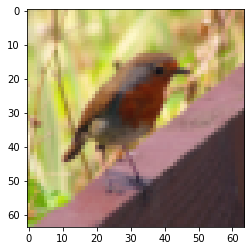

In [61]:
index = 10
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [62]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

In [63]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [64]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        cost = compute_cost(A2, Y)
        dA2 = - (np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        if print_cost and i%100 == 0:
            print("cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i%100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    return parameters

In [65]:
parameters = two_layer_model(train_x, train_y, layers_dims, num_iterations=2500, print_cost=True)

KeyError: 'W1'

In [ ]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [ ]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [ ]:
layers_dims = [12288, 20, 7, 5, 1]

In [ ]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layer_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i%100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


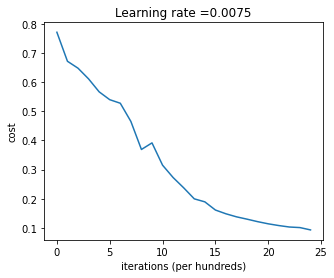

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=2500, print_cost=True)

In [ ]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [ ]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


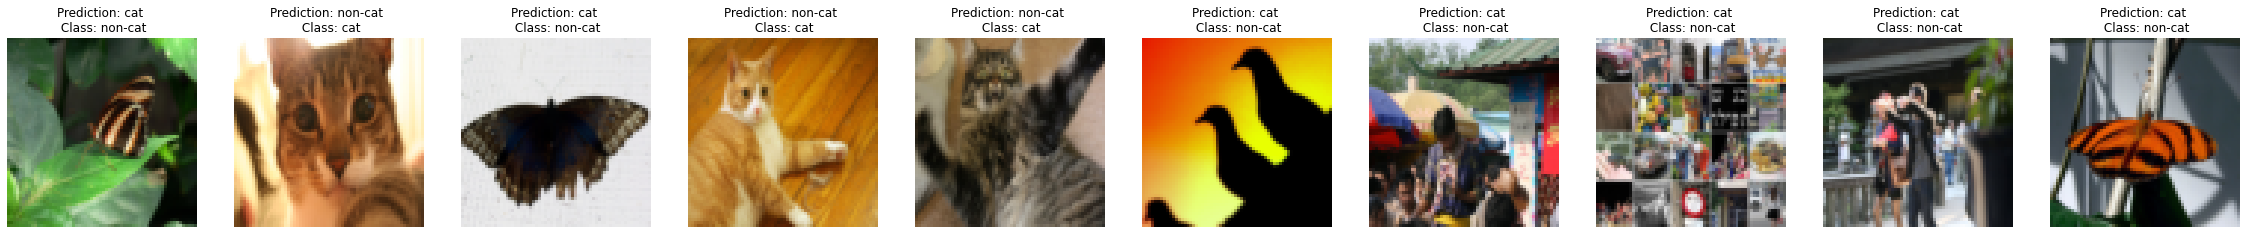

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


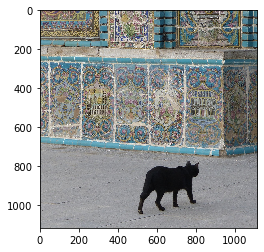

In [67]:
my_image = "cat_in_iran.jpg"
num_px = train_x_orig.shape[1]
my_label_y = [1]
fname = "images/" + my_image
image = np.array(imageio.imread(fname, as_gray=False))
my_image = np.array(Image.fromarray(image).resize((num_px, num_px))).reshape(1, num_px * num_px * 3).T
my_image = my_image / 255.
my_predicted_image = predict(my_image, my_label_y, parameters)
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")